## Case Study: Chapter 7 - NorthGrid–SouthGrid Transmission Corridor Expansion

 Authors:   Neeraj Dhanraj Bokde  (www.neerajbokde.in)
            and Carlo Fanara
            
 Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi
 
 Corresponding author: neeraj.bokde@tii.ae / neerajdhanraj@gmail.com

 Description:
   Implements the transmission planning case study from Chapter 7
   ("Transmission Planning and Expansion") of The PyPSA Handbook.
   Models a greenfield system with two spatially separated regions—NorthGrid
   (wind/solar-rich) and SouthGrid (demand/gas backup)—linked by two alternative
   extendable transmission corridors. All investments (generation, storage,
   corridors) are co-optimised under cost, emissions, and infrastructure limits.
   Illustrates spatial vs temporal flexibility, corridor selection, and policy
   constraint effects on system design and operation. Includes publication-ready
   plots and tabular output diagnostics.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Transmission Planning and Expansion.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable
   Energy Modeling, Chapter 7.
   Publisher: Elsevier Science
   ISBN: 044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy, pandas, matplotlib
   - cartopy (optional, for advanced mapping)

 License: MIT
 
 Version: 1.0
 
 Date: June 2025

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


#### 1. Network Setup and Time Horizon

Initialize a blank PyPSA network

In [2]:
network = pypsa.Network()

Set the simulation period: 168 hours (1 week, hourly resolution)

In [3]:
snapshots = pd.date_range("2025-01-01 00:00", periods=168, freq="h")
network.set_snapshots(snapshots)

#### 2. Buses and Spatial Configuration

Define key buses: wind, solar, storage, and internal/external hubs

In [4]:
buses = [
    "NorthWind", "NorthSolar", "NorthStorage", "NorthHub",
    "SouthHub", "SouthLoad", "SouthBackupGen"
]
for b in buses:
    network.add("Bus", b)

Assign synthetic geographic coordinates for visualisation (arbitrary, not geo-accurate)

In [5]:
bus_coords = {
    "NorthWind": (10.0, 56.0),
    "NorthSolar": (11.0, 56.1),
    "NorthStorage": (10.5, 55.8),
    "NorthHub": (10.5, 55.5),
    "SouthHub": (10.5, 54.5),
    "SouthLoad": (10.3, 54.2),
    "SouthBackupGen": (10.7, 54.1)
}
for bus, (x, y) in bus_coords.items():
    network.buses.at[bus, "x"] = x
    network.buses.at[bus, "y"] = y

#### 3. Demand Profile (SouthGrid)

Synthetic sinusoidal demand profile, 300 ± 60 MW over one week

In [6]:
load_profile = pd.Series(300 + 60 * np.sin(np.linspace(0, 3*np.pi, 168)), index=snapshots)
network.add("Load", "SouthDemand", bus="SouthLoad", p_set=load_profile)

#### 4. Renewable Generation Profiles

Generate reproducible wind and solar availability

In [7]:
np.random.seed(0)
wind_profile = pd.Series(np.clip(np.random.normal(0.6, 0.2, 168), 0, 1), index=snapshots)
wind_profile[60:70] = 0.2  # Deliberate wind lull to test system flexibility
solar_profile = pd.Series(np.maximum(0, np.sin(np.linspace(0, 7*np.pi, 168))), index=snapshots)

#### 5. Generator and Storage Asset Definitions

Extendable wind generator (NorthGrid)

In [8]:
network.add("Generator", "WindNorth", bus="NorthWind",
            p_nom_extendable=True,
            p_max_pu=wind_profile,
            capital_cost=800,
            marginal_cost=0)

Extendable solar generator (NorthGrid)

In [9]:
network.add("Generator", "SolarNorth", bus="NorthSolar",
            p_nom_extendable=True,
            p_max_pu=solar_profile,
            capital_cost=200,
            marginal_cost=0)

Extendable gas generator (SouthGrid, backup only, high emissions/cost)

In [10]:
network.add("Generator", "GasSouth", bus="SouthBackupGen",
            p_nom_extendable=True,
            capital_cost=600,
            marginal_cost=70,
            carrier="gas")

Battery storage (NorthGrid), extendable size, moderate efficiency

In [11]:
network.add("StorageUnit", "Battery_North", bus="NorthStorage",
            p_nom_extendable=True,
            max_hours=4,
            efficiency_store=0.9,
            efficiency_dispatch=0.9,
            capital_cost=200,
            marginal_cost=0.01)

#### 6. Network Topology: Internal Links and Transmission Corridors

High-capacity internal links (fixed, non-binding within each zone)

In [12]:
internal_links = [
    ("NorthWind", "NorthHub"),
    ("NorthSolar", "NorthHub"),
    ("NorthStorage", "NorthHub"),
    ("SouthHub", "SouthLoad"),
    ("SouthBackupGen", "SouthHub")
]
for a, b in internal_links:
    network.add("Link", f"{a}_to_{b}", bus0=a, bus1=b, p_nom=1000, efficiency=1.0)

Two parallel, extendable inter-regional corridors: A (costlier), B (cheaper)

In [13]:
network.add("Link", "Corridor_A", bus0="NorthHub", bus1="SouthHub",
            p_nom_extendable=True, efficiency=1.0,
            capital_cost=200, carrier="AC")

network.add("Link", "Corridor_B", bus0="NorthHub", bus1="SouthHub",
            p_nom_extendable=True, efficiency=1.0,
            capital_cost=150, carrier="AC")

Global limit on total inter-zonal corridor buildout (forces trade-off)

In [14]:
network.add("GlobalConstraint", "max_corridor_expansion",
            type="transmission_volume_expansion_limit",
            carrier_attribute="carrier",
            sense="<=",
            constant=200)

#### 7. Emissions Constraint (CO2 Cap)

Define CO2 emission factor for gas, and a system-wide cap

In [15]:
network.add("Carrier", "gas", co2_emissions=0.2)
network.add("GlobalConstraint", "co2_limit",
            type="primary_energy_cap",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=10000)

#### 8. Model Solution

Solve the co-optimisation problem: all assets sized/used for lowest cost

network.optimize(solver_name="highs", pyomo=True, keep_shadowprices=True)

In [16]:
network.optimize(solver_name="glpk")

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.89s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2190 primals, 5718 duals
Objective: 9.09e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-z1_5vslp.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-tbb2iazx.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-z1_5vslp.lp'...
5718 rows, 2190 columns, 9507 non-zeros
34931 lines were read
GLPK Simplex Optimizer 5.0
5718 rows, 2190 columns, 9507 non-zeros
Preprocessing...
2372 rows, 1874 columns, 5845 non-zeros
Scaling...
 A: min|aij| =  3.761e-02  max|aij| =  4.000e+00  ratio =  1.063e+02
GM: min|aij| =  6.666e-01  max|aij| =  1.500e+00  ratio =  2.250e+00
EQ: min|aij| =  4.446e-01  max|aij| =  1.000e+00  ratio =  2.249e+00
Constructing initial basis...
Size of triangular part is 2204
      0: obj =   0.000000000e+00 inf =   8.833e+04 (290)
    243: obj =   3.892800603e+06 inf =   5.684e-14 (0) 2
*   911: obj =   9.092775669e+05 inf =   0.000e+00 (0) 6
OPTIMAL LP SOLUTION FOUND
Time used:  

('ok', 'optimal')

#### 9. Results Visualisation and Diagnostics

This section generates all key diagnostic plots and tables for the case study:

- Hourly generation dispatch (stacked area)

- Inter-regional transmission flows (Corridor A and B)

- Marginal electricity prices at each bus

- Renewable curtailment time series

- Network schematic with labeled corridors

- Corridor buildout bar chart (investment decision)

- Tabular summary of optimal asset buildout and key metrics

All plots are saved as vector PDF files for direct use in reports or publications.

In [17]:
import matplotlib.pyplot as plt

1. Generation Dispatch (Stacked Area Plot)

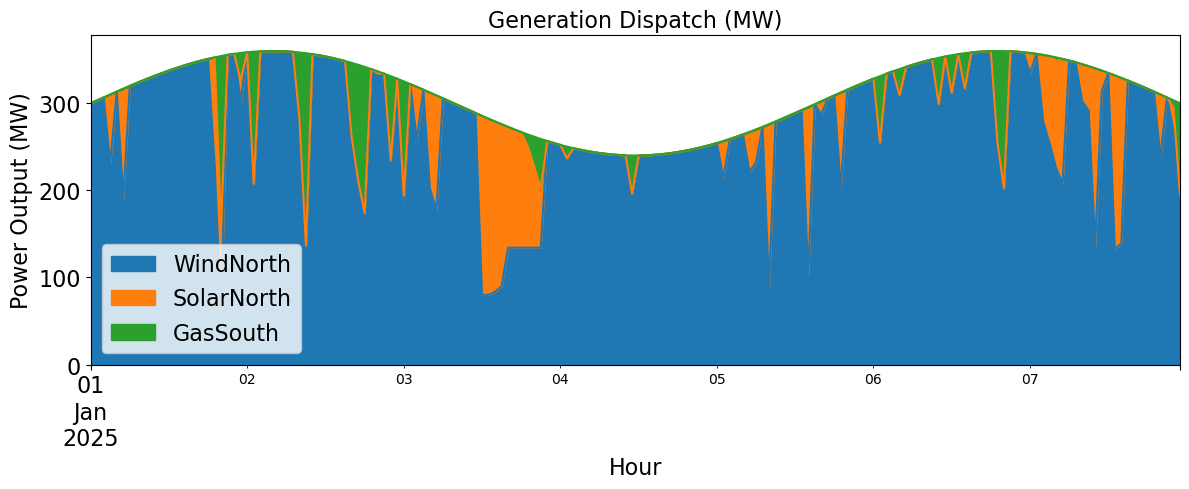

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
network.generators_t.p.plot.area(ax=ax)
ax.set_title("Generation Dispatch (MW)", fontsize=16)
ax.set_ylabel("Power Output (MW)", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

2. Transmission Flows: Corridor A vs Corridor B

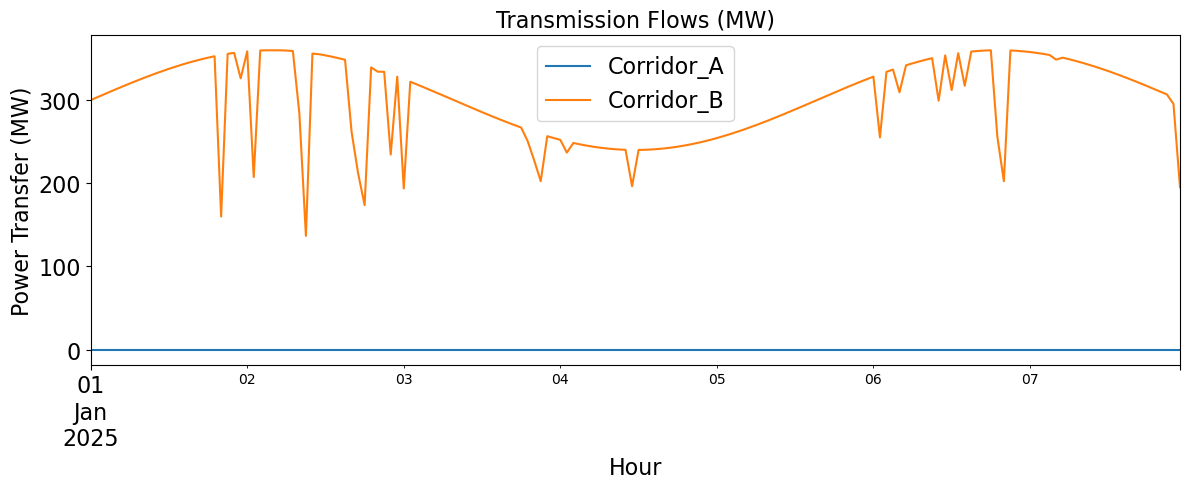

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
network.links_t.p0[["Corridor_A", "Corridor_B"]].plot(ax=ax)
ax.set_title("Transmission Flows (MW)", fontsize=16)
ax.set_ylabel("Power Transfer (MW)", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

3. Marginal Prices (€/MWh) Across Buses

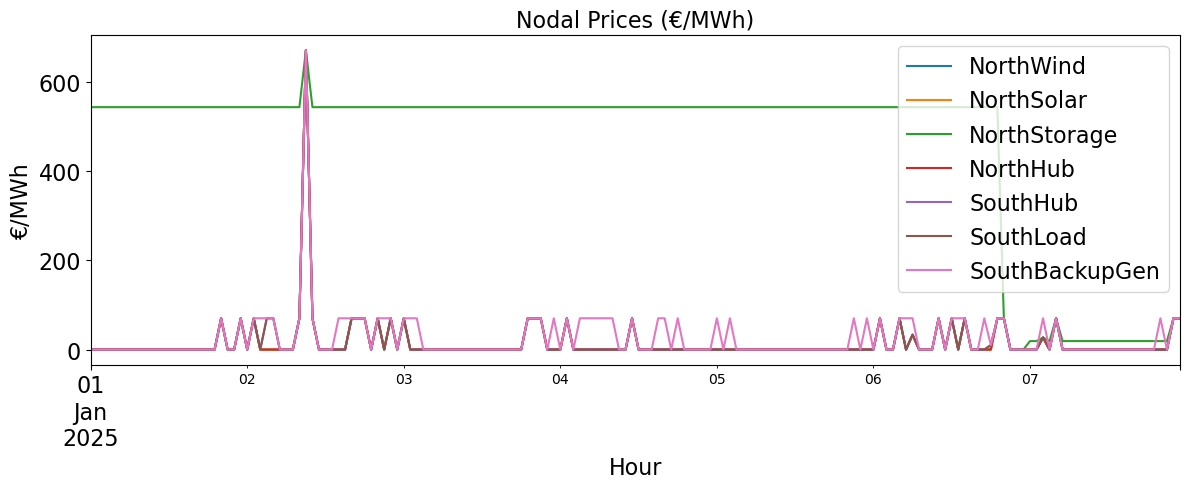

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
network.buses_t.marginal_price.plot(ax=ax)
ax.set_title("Nodal Prices (€/MWh)", fontsize=16)
ax.set_ylabel("€/MWh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

4. Renewable Curtailment Over Time

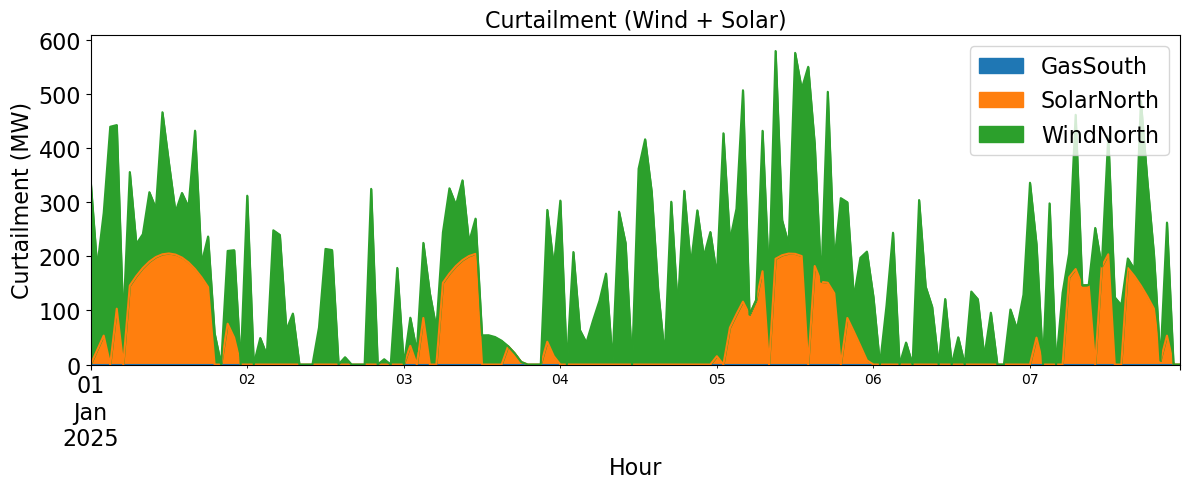

In [21]:
available = network.generators_t.p_max_pu.multiply(network.generators.p_nom_opt, axis=1)
curtailment = (available - network.generators_t.p).clip(lower=0)
fig, ax = plt.subplots(figsize=(12, 5))
curtailment.plot.area(ax=ax)
ax.set_title("Curtailment (Wind + Solar)", fontsize=16)
ax.set_ylabel("Curtailment (MW)", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

5. Network Schematic with Labeled Corridors

(<matplotlib.collections.PatchCollection at 0x21899a83b20>,
 <matplotlib.collections.LineCollection at 0x21899ab0bb0>)

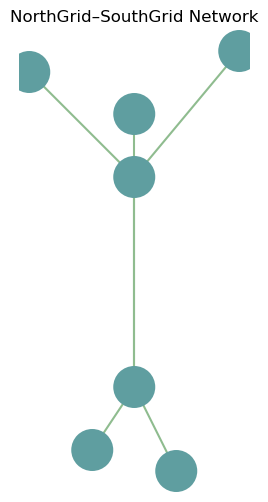

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
network.plot(
    ax=ax,
    title="NorthGrid–SouthGrid Network",
    bus_sizes=0.01,
    line_widths=network.links.p_nom_opt / 10,
    line_colors="gray",
    geomap=False
)

Annotate buses

In [23]:
for bus in network.buses.index:
    x = network.buses.at[bus, 'x']
    y = network.buses.at[bus, 'y']
    ax.text(x + 0.1, y + 0.1, bus, fontsize=12, ha='left', va='bottom')

Draw and label Corridors A and B with offsets for clarity

In [24]:
bus_coords = network.buses[["x", "y"]]
nh = bus_coords.loc["NorthHub"]
sh = bus_coords.loc["SouthHub"]
offset = 0.1

Corridor A (blue)

In [25]:
ax.plot([nh.x - offset, sh.x - offset], [nh.y, sh.y], color="blue", linewidth=3)
ax.text((nh.x - offset + sh.x - offset)/2 - 0.4, (nh.y + sh.y)/2 + 0.1,
        "Corridor A", color="blue", fontsize=11)

Text(9.999999999999998, 55.1, 'Corridor A')

Corridor B (red)

In [26]:
ax.plot([nh.x + offset, sh.x + offset], [nh.y, sh.y], color="red", linewidth=3)
ax.text((nh.x + offset + sh.x + offset)/2 + 0, (nh.y + sh.y)/2 - 0.1,
        "Corridor B", color="red", fontsize=11)

Text(10.600000000000001, 54.9, 'Corridor B')

Adjust axis padding for better visual balance

In [27]:
x_min, x_max = network.buses["x"].min(), network.buses["x"].max()
y_min, y_max = network.buses["y"].min(), network.buses["y"].max()
x_padding = (x_max - x_min) * 0.1
y_padding = (y_max - y_min) * 0.1
ax.set_xlim(x_min - x_padding, x_max + x_padding)
ax.set_ylim(y_min - y_padding, y_max + y_padding)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

6. Corridor Buildout Bar Chart

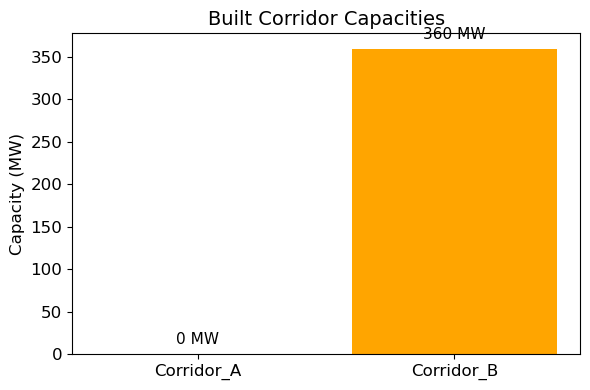

In [28]:
corridors = ["Corridor_A", "Corridor_B"]
capacities = [network.links.at[c, "p_nom_opt"] for c in corridors]
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(corridors, capacities, color=["blue", "orange"])
ax.set_title("Built Corridor Capacities", fontsize=14)
ax.set_ylabel("Capacity (MW)", fontsize=12)
ax.tick_params(labelsize=12)
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f} MW',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

7. Tabular Outputs and Key Metrics

In [29]:
print("\n--- Generator Capacities (Optimal) ---")
print(network.generators[["bus", "p_nom_opt"]])

print("\n--- Corridor Capacities (Optimal) ---")
for link in ["Corridor_A", "Corridor_B"]:
    print(f"{link}: {network.links.at[link, 'p_nom_opt']:.2f} MW")

print("\n--- Battery Capacity (Optimal) ---")
print(network.storage_units.at["Battery_North", "p_nom_opt"])

print("\n--- Total System Cost (Objective) ---")
print(f"{network.objective:.2f} EUR")

print("\n--- Peak Marginal Price (€/MWh) ---")
print(network.buses_t.marginal_price.max().max())


--- Generator Capacities (Optimal) ---
attribute              bus  p_nom_opt
Generator                            
WindNorth        NorthWind    670.963
SolarNorth      NorthSolar    205.510
GasSouth    SouthBackupGen    220.698

--- Corridor Capacities (Optimal) ---
Corridor_A: 0.00 MW
Corridor_B: 359.87 MW

--- Battery Capacity (Optimal) ---
0.0

--- Total System Cost (Objective) ---
909277.57 EUR

--- Peak Marginal Price (€/MWh) ---
670.0


#### End of Results Section for NorthGrid–SouthGrid Transmission Planning